In [1]:
import pandas as pd 
import sqlite3
import seaborn as sns

# Doc-Level Aggregate Statistics

Here, we show some of the aggregate statistics that you have at your disposal to manipulate.

In [41]:
# first, download and unzip into the expected folder.

conn = sqlite3.connect('ap-matched-sentences.db')

In [42]:
pd.read_sql('''SELECT 
                    name
                FROM 
                    sqlite_master 
                WHERE 
                    type ='table' AND 
                    name NOT LIKE 'sqlite_%';
''', con=conn)

,name
0,matched_sentences
1,split_sentences
2,doc_level_stats


In [43]:
pd.read_sql('select * from doc_level_stats limit 5', con=conn)

,entry_id,version_x,version_y,mean x dist,mean y dist,num_unchanged,num_edited_x,num_edited_y,num_deleted,num_added,num_merged,num_split,num_sentences_x,num_sentences_y,num_refactors,mean_dist_overall
0,1,0,1,0.011069,0.020067,26,19,20,0,1,0,1,45,47,0,0.015568
1,1,1,2,0.040247,0.039950,19,20,20,8,4,1,1,47,43,1,0.040099
2,2,0,1,0.008678,0.008655,20,19,19,1,1,0,0,40,40,0,0.008666
3,2,1,2,0.015470,0.015509,37,3,3,0,0,0,0,40,40,0,0.015489
4,2,2,3,NaN,NaN,0,0,0,33,69,0,0,33,69,0,NaN


In [44]:
doc_level_stats_df = pd.read_sql('select * from doc_level_stats', con=conn)

In [45]:
doc_level_stats_df.shape[0]

61518

In [46]:
pd.read_sql(
    '''SELECT count(1) as count_matched_versions
        FROM (select distinct entry_id, version_x, version_y from matched_sentences)
    '''
    , con=conn)

,count_matched_versions
0,61518


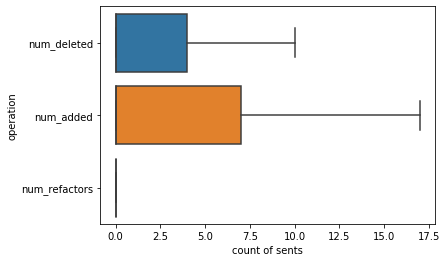

In [47]:
(doc_level_stats_df[['num_deleted', 'num_added', 'num_refactors']]
 .unstack()
 .reset_index()
 .drop('level_1', axis=1)
 .rename(columns={'level_0': 'operation', 0: 'count of sents'})
 .pipe(lambda df: sns.boxplot(data=df, x='count of sents', y='operation', showfliers=False))
)

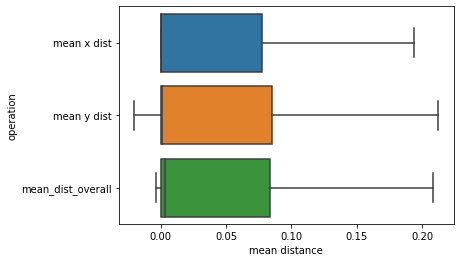

In [48]:
(doc_level_stats_df
 [['mean x dist', 'mean y dist', 'mean_dist_overall']]
  .unstack()
  .reset_index()
  .drop('level_1', axis=1)
  .rename(columns={'level_0': 'operation', 0: 'mean distance'})
  .pipe(lambda df: sns.boxplot(data=df, x='mean distance', y='operation', showfliers=False))
)

# Filter Documents by Statistics

Now, we might want to study a small subset of articles that we expect to have certain characteristics. For example, lets say we wish to study articles that:

* have low version number 
* start small 
* and grow larger

as we expect these will capture some characteristics of breaking news.

Here, we show the that we can filter by a number of different fields to get that subset of articles.

In [49]:
num_versions = doc_level_stats_df['entry_id'].value_counts().to_frame('num_versions')

In [50]:
candidate_articles = (
    doc_level_stats_df
    .merge(num_versions, left_on='entry_id', right_index=True)
    .loc[lambda df: (df['version_x'] / df['num_versions']) < .2]  ## articles early in their lifecycle
    .loc[lambda df: df['num_sentences_x'] < 20]                   ## short articles
    .loc[lambda df: df['num_added'] / df['num_sentences_x'] > .4] ## articles that grow between iterations
)

In [51]:
keys = (
    candidate_articles
    .pipe(lambda df: df.apply(lambda x: '%s-%s' % (
                int(x['entry_id']),
                int(x['version_x'])
            )
        , axis=1)
    )
).tolist()
keys = list(map(lambda x: "'%s'" % x, keys))
keys = ', '.join(keys)

In [52]:
candidate_article_df = pd.read_sql(
'''WITH c1 as ( 
        SELECT *, 
        CAST(entry_id AS INT) || '-' || CAST(version AS INT) as key
        FROM split_sentences
        )
        SELECT entry_id, version, sent_idx, sentence
        FROM c1
        WHERE key in (%s)''' % keys
, con=conn)

In [53]:
candidate_article_df

,entry_id,version,sent_idx,sentence
0,19161,0.0,0,"<p>BEDMINSTER, N.J. (AP) — President Donald Tr..."
1,19161,0.0,1,</p> <p>Trump made the bold prediction Tuesday...
2,19161,0.0,2,</p> <p>Trump is also hailing his own economic...
3,19161,0.0,3,</p> <p>The government reported last month tha...
4,19161,0.0,4,</p>
...,...,...,...,...
34314,9327,0.0,1,</p> <p>Antonio Guterres on Friday addressed a...
34315,9327,0.0,2,</p> <p>Guterres has said Uganda last year rec...
34316,9327,0.0,3,</p> <p>He called South Sudan's refugee influx...
34317,9327,0.0,4,Most have arrived in the past year.


# We'll perform a small investigation of these negative distances

Here we examine one example of where a distance is negative and conclude that it is likely the result of approximation  errors in the dot-product.

In [54]:
neg_sents = pd.read_sql('select * from matched_sentences where avg_sentence_distance_y < 0', con=conn)

In [55]:
neg_sents

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,4263,9,10,46.0,46.0,0.119313,-0.058030
1,4263,15,16,46.0,46.0,0.119313,-0.058030
2,4263,7,8,46.0,46.0,0.119313,-0.058030
3,4263,19,20,46.0,46.0,0.119313,-0.058030
4,4263,13,14,46.0,46.0,0.119313,-0.058030
...,...,...,...,...,...,...,...
59,1835,2,3,82.0,15.0,NaN,-0.020485
60,8147,5,6,27.0,101.0,0.201872,-0.020485
61,1160,1,2,9.0,32.0,0.201872,-0.020485
62,1135,0,1,20.0,12.0,NaN,-0.020485


In [59]:
e, v_x, v_y = 4263, 9, 10

In [60]:
import sys
sys.path.insert(0, '..')

In [61]:
import util.util_data_fetching_for_app as uda
from jinja2 import Template, Environment, FileSystemLoader
import datetime
from IPython.display import display, HTML

# 1. set up the Jinja environment and select the template we will write to
jinja_env = Environment(loader=FileSystemLoader('../evaluation/templates'))
template = jinja_env.get_template('visualize-doc-level-edits.html')

# 2. select one target article and do some processing
one_article_matched_df = pd.read_sql('''
    select * from matched_sentences where entry_id = %s and version_x = %s and version_y = %s
''' % (e, v_x, v_y),  con=conn).assign(source='wp')

one_article_sentences_df = (
     pd.read_sql('''
        select * from split_sentences where entry_id = %s and version in (%s, %s)
''' % (e, v_x, v_y), con=conn)
        .assign(source='wp')
)

data_to_render = uda.match_sentences(one_article_matched_df, one_article_sentences_df)
data_dict_for_rendering = uda.dump_output_to_app_readable(data_to_render)
one_key = list(data_dict_for_rendering.keys())[0]
one_doc_to_render = data_dict_for_rendering[one_key]

# 3. write to the template, generating a full HTML file, and write this to disk
html = template.render(
    data=one_doc_to_render,
    doc_id=one_key,
    do_mturk=False,
    start_time=str(datetime.datetime.now()),
)

In [70]:
from html2image import Html2Image

hti = Html2Image()
hti.screenshot(html_str=[html], save_as='img/test-screenshot.png', size=(800, 7200))

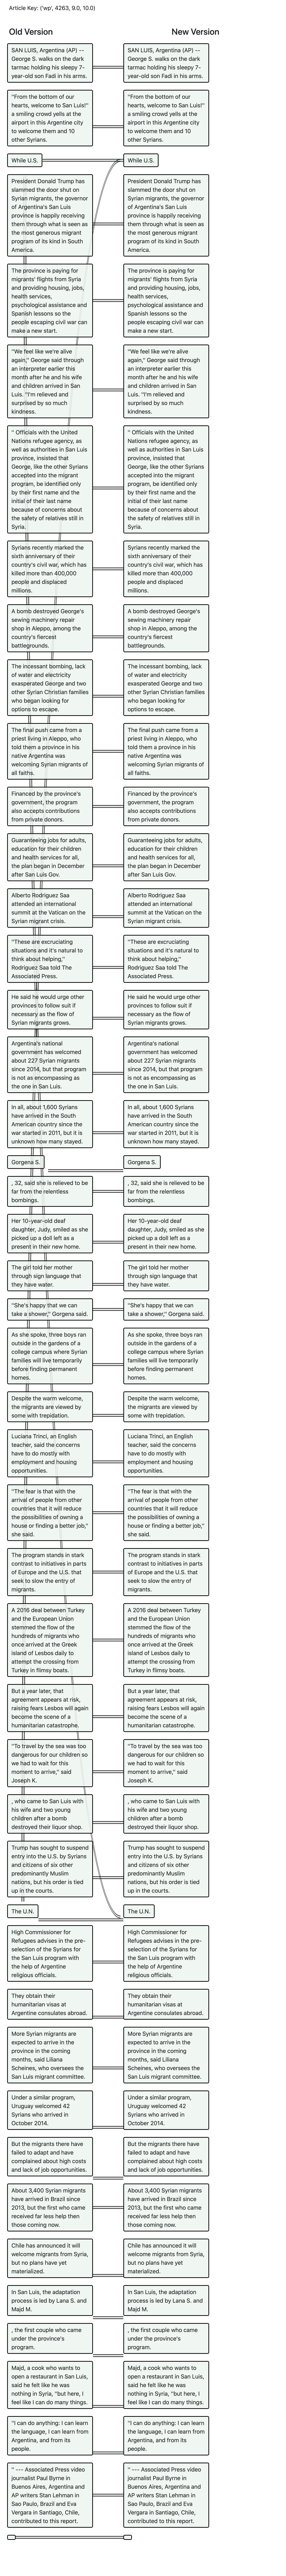

In [99]:
from IPython.display import Image
Image(filename='img/test-screenshot.png')